# Tutorial 5 - Deploying Stage

We got to the stage of packaging and deploying our Deep Learning model. To do that - first several things need to be prepared. It will not be sufficient to use .ipynb files for deployment, therefore standard .py files will have to be utilized. Howver, for convenience - most of the information still can be prepared initially in the Jupyter Notebook. So what needs to be prepared is a single executable script that would call the loading of the model we have created and one that will make needed predictions with files renaming. Later, small adjustments will have to be done to repackage it into a .py format and we will be ready to bring the model to deployment.

Let's proceed with preparing a one do it all funciton. Idealy, put all of the files you might need into the same folder (i.e. .ipynb file, model, .py file, folder with numbers to predict). This will become clear and convenient when we will move to packaging the model for deployment.

In [34]:
def predict_numbers(demonstration = False):
    """
    This is a do it all in one function for loading a trained model for predicting
    handwritten digits from pictures and then renaming those pictures.
    
    > demonstration - indicate whether you want to see what files are being worked with and predictions on them.
    """
    
    # (0) Make all the required imports
    import torch                              
    import torch.nn as nn                                       
    from torchvision import transforms 
    import cv2
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import os
    from os import walk
    from os.path import join
    
    # (1) Prepare and load the model
    
    # Load the device the user will use
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cpu')
    
    class Network(nn.Module):
        def __init__(self):                                             
            super(Network, self).__init__()                             
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels = 1,
                                       out_channels = 16,
                                       kernel_size = 5,
                                       stride = 1,
                                       padding = 2),                        
                nn.ReLU(),                                                
                nn.MaxPool2d(kernel_size=2, 
                             stride=2)                                    
                )

            self.conv2 = nn.Sequential(
                nn.Conv2d(in_channels = 16,
                                       out_channels = 32,
                                       kernel_size = 5,
                                       stride = 1,
                                       padding = 2),                        
                nn.ReLU(),                                                
                nn.MaxPool2d(kernel_size = 2,
                             stride = 2)                                    
                )

            self.fc1 = nn.Linear(in_features = 7*7*32,                  
                                 out_features = 10)                    

        def forward(self, t):
            out = self.conv1(t)
            out = self.conv2(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc1(out)
            return out

    # Load the model into an executable form
    model = Network().to(device)
    
    # (2) Load weights into the model that were trained
    # And adjustment - we have to load the model as a cpu too
    model.load_state_dict(torch.load("model.ckpt", map_location=torch.device('cpu')))
    
    # (3) Prepare the images pre-processing function
    def images_preprocess(path):
        """
        An image is preprocessed and returned in a form that 
        the NN model understands.
        """
        img = cv2.imread(path, 0)                      
        img_inv = cv2.bitwise_not(img)                 
        img_inv_res = cv2.resize(img_inv, (28, 28))    
        img_inv_res_tensor = torch.tensor(img_inv_res)
        
        if demonstration == True:
            plt.imshow(img_inv_res_tensor, cmap = "gray")
            plt.show()
        return img_inv_res_tensor

    # (4) Prepare image accumulating variable (users' images)
    storage = "ToPredict/"  
    images = []     

    files = []
    for (dirpath, dirnames, filenames) in walk(storage):
        files.extend(filenames)

    for file in files:
        image = images_preprocess(join(storage, file))
        images.append(image)
        
    # (5) Prepare the data loader to the model
    loader_images = torch.utils.data.DataLoader(dataset = images,
                                                batch_size = 16,
                                                shuffle = False)
    
    # (6) Prepare the predictions making function
    def prediction(model, data_loader):
        """
        Make predictions with the model.
        """
        model.eval()
        all_predictions = []
        final_predictions = []

        with torch.no_grad():  

            # Predict one by one
            for images in data_loader:
                images = images.reshape(-1, 1, 28, 28).to(device, dtype=torch.float) 
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_predictions.append(predicted.cpu().numpy())

            for entry in all_predictions:
                for value in entry:
                    final_predictions.append(value)
                    
            if demonstration == True:
                print(final_predictions)
                
            return final_predictions
    
    # (7) Make the actual predictions
    predicted = prediction(model = model,
                           data_loader = loader_images)
    
    # (8) Rename the files
    counter = 0
    for (dirpath, dirnames, filenames) in walk("ToPredict"):
        for file in filenames:
            os.rename("ToPredict/" + str(filenames[counter]), "ToPredict/" + "Case" + str(counter) + "_" + str(predicted[counter]) + ".png")
            counter += 1

Now that our main massive function is prepared - it is a good idea to test it. For it, I have create my own set of written digits on a piece of paper to see applicabiity of this model to real world problems. As well as, I added numbers taken from online from Tutorial 4. They can be viewed as they are stored in the `Numbers` folder as a backup in their original form.

Now, let's execute the model and see if it works properly.

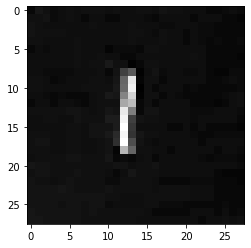

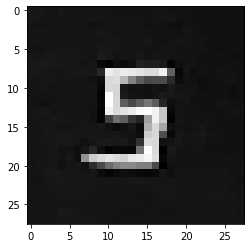

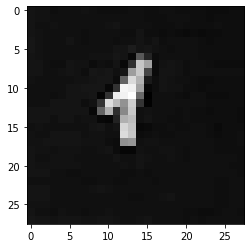

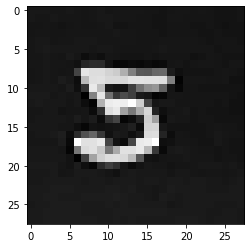

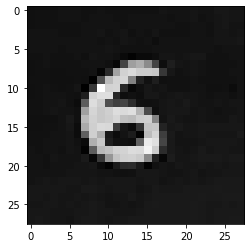

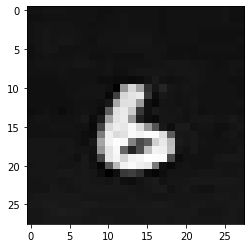

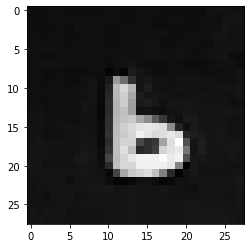

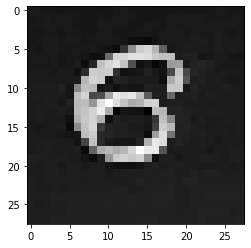

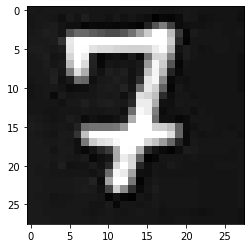

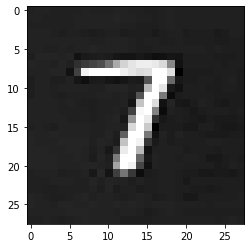

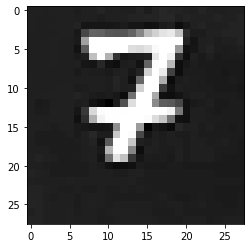

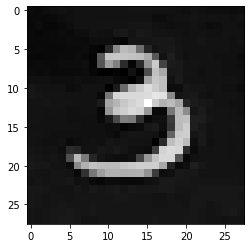

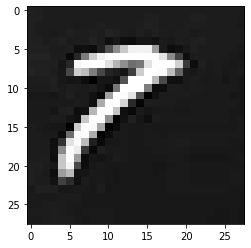

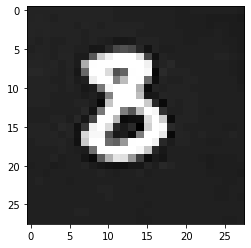

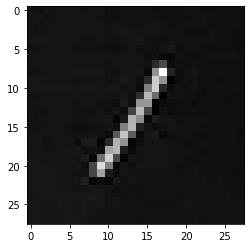

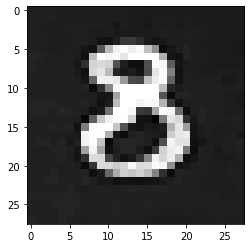

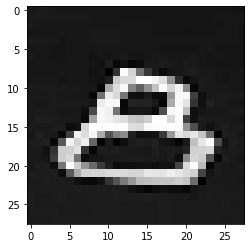

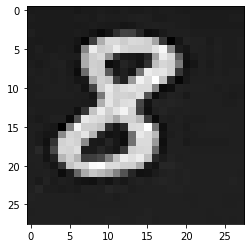

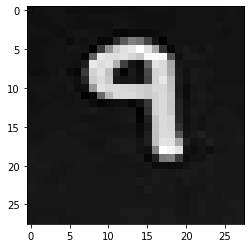

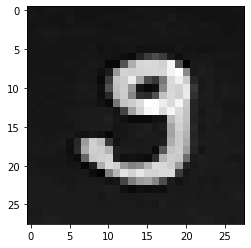

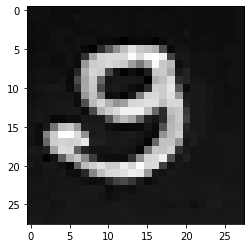

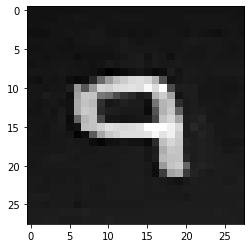

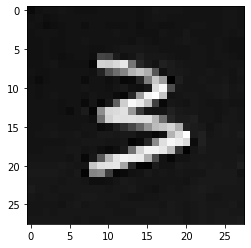

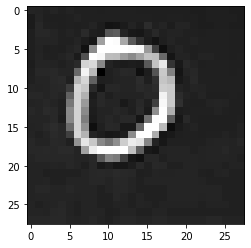

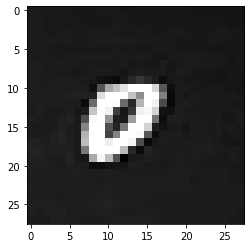

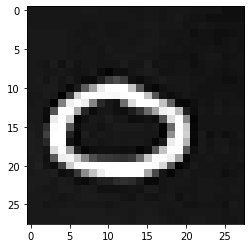

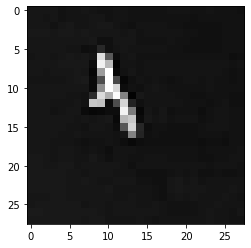

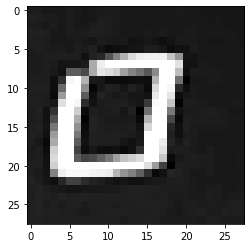

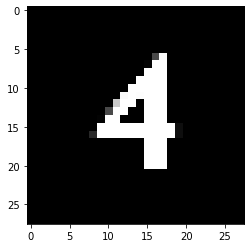

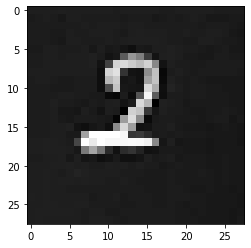

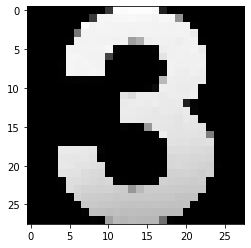

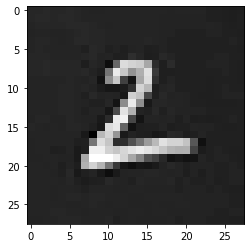

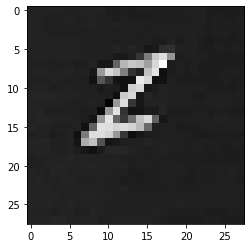

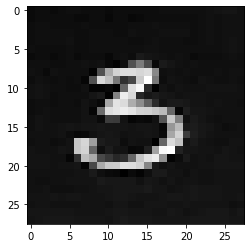

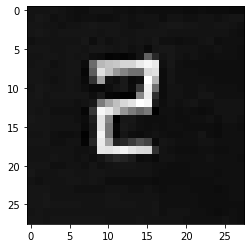

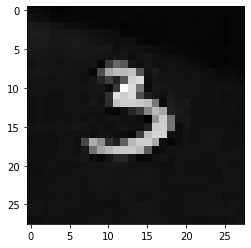

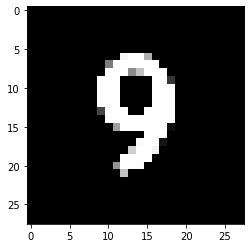

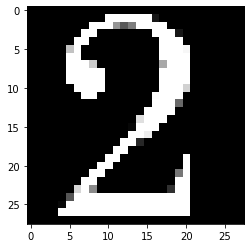

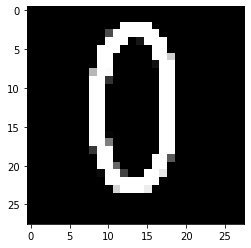

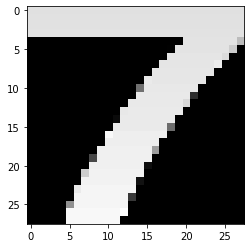

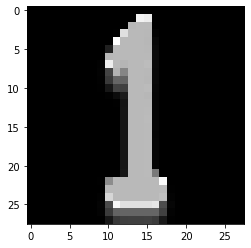

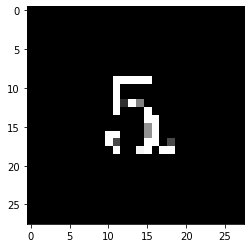

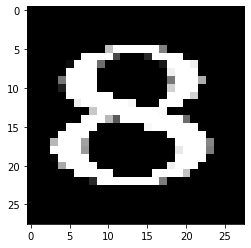

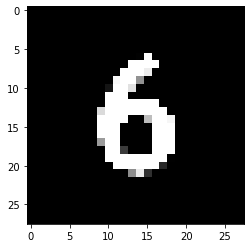

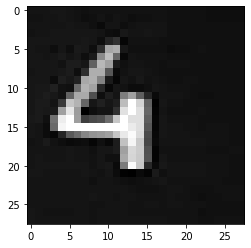

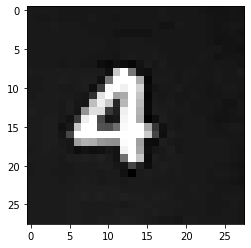

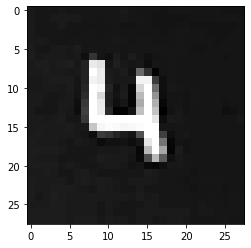

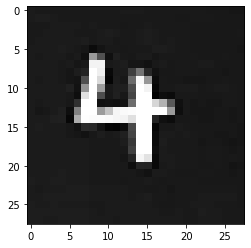

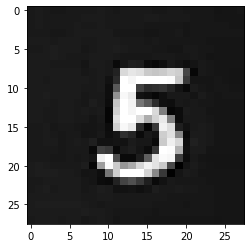

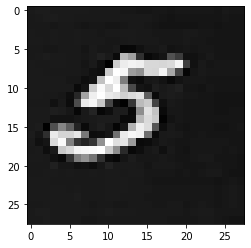

[2, 5, 1, 2, 6, 6, 6, 2, 6, 2, 2, 3, 2, 6, 2, 8, 6, 2, 2, 3, 2, 6, 2, 2, 2, 6, 1, 2, 4, 2, 3, 2, 2, 6, 2, 2, 9, 1, 0, 1, 1, 5, 8, 6, 1, 2, 4, 4, 5, 2]


In [35]:
predict_numbers(demonstration = True)

The execution happened. The files have had predictions made on them and they were renamed. 

As can be noticed - it seems my handwritting is really confussing to the model we made...well. It still works though with numbers taken from online. Gladly, we do not need to put this into production where a lot of people's lifes will depend on it. For demonstration purposes this will do. Let's move to packaging everything into a .py file. This file will use few argument commands on the input, in order for us to be able to run the prepared model in a simple command prompt (or terminal if you are on Linux or Mac). Further however, most of the instructions do assume that you are using a Windows OS, however, only minor adjustments would require to be done, if you were using a different system.

This is the way the file with our function will look:

To execute it - essentially you need to navigate into the virtual environment you are working with all your needed packages prepared, navigate to the folder where this file is located in a .py file, pass all your images on which predictions need to be made into a `ToPredict` folder and run it...which is tidious and requires a lot of steps to be taken, including hopes that your user has also python of the correct version prepared and can do so without mistakes.

That is why further a software called `Docker` will be used: https://www.docker.com/get-started

In simple words - Docker essentially is a virtual machine type environment. It will have everything needed to allow your function to run, including the function itself. After preparing it - the user will be required only to execute a short command line in a command line prompt window that will call Docker with the function prepared inside, which will run. We will prepare the set up in such way, that the Docker will be looking for a specific folder on user's computer to read images from, without the user worrying about making lots of preparations to run everything.

There are two ways how this can be handled:
* First way is that the user will take the required files to prepare the Docker image and run it.
* Second way is that we prepare everything and the user will only have to download the image of the Docker environment we prepare from online. 

Before getting into both of those ways - first go to the Docker website and install the software. Follow the instructions on it. For Windows users - you might run into a small problem, and that is the Docker might require you to activate `Hyper-V` on your machine. To do that - press the `Windows` key, search for `Windows Features` and activate the `Hyper-V` checkbox if it is still not activated.

__Word of caution__: Docker does work much more smoother on the Linux operational systems. But this instructional manual assumes you are a more standard user (just like me), who does most of the job on a Windows system.

I assume you have prepared Docker and started it.

Now let us package our files into it. But before that, we need to check first what package version we are working with, to get them set up in the same fashion in the Docker container of ours.

In [36]:
import torch                              
import torch.nn as nn    
import torchvision
from torchvision import transforms 
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from os import walk
from os.path import join
from platform import python_version

import PIL # Extra for images

print("PyTorch version==={}".format(torch.__version__))
print("Torchvision version==={}".format(torchvision.__version__))
print("opencv-python==={}".format(cv2.__version__))
print("matplotlib==={}".format(matplotlib.__version__))
print("Python version used: {}".format(python_version()))
print("Pillow==={}".format(PIL.__version__))

PyTorch version===1.2.0
Torchvision version===0.4.0
opencv-python===3.4.2
matplotlib===3.1.1
Python version used: 3.7.4
Pillow===6.1.0


First create the `requirements.txt` file in the folder you have all of your codes stored. And fill it with the following information:

torch===1.2.0

opencv-python===3.4.2.17

matplotlib===3.1.1

This will be the main packages and their version that we will require to use.

Next, create a file called `Dockerfile`. That's correct, it should have no file formats, no nothing. Populate it with the following information (through a text editor of your choice):

FROM python:3.7.7-buster

COPY ./requirements.txt /requirements.txt

RUN pip3 install -r requirements.txt

ADD model.ckpt /

ADD PyTorch_Deploy.py /

ADD ToPredict /

ENTRYPOINT ["python", "./PyTorch_Deploy.py"]


Essentially, you are first installing a python image available from pre-existing with Docker: https://hub.docker.com/_/python Then you are installing all of the needed packages you want to work with from the requirements.txt file you indicated earlier. Then you are moving the files you have indicated with an ADD command to the Docker virtual image that you create. After which you specify the entry point, which is essentially how you want to run your code. And here it is done as with a simple CMD prompty - when you first call python and then the executable file.

Now navigate in your cmd to the folder where you have all of your files stored (i.e. what is used in this tutorial) and run the following command: `docker build -t numbers .` This will build a Docker image called numbers. After the installation is done, you can view it by running the command `docker images` in a cmd prompt anywhere on your system.

You can run the command through a cmd `docker container run --rm numbers -h`. This will initiate the container of your image created, run the help function we created in our script that gives a short notice: 

                                Description:
--------------------------------------------------------------------------
                   Run predictions on numbers in images
--------------------------------------------------------------------------

And then exits and closes the running image instance. 

If you want to execute your script you should run the command almost in the same fashion: `docker container run --rm numbers`.

If eveything worked out correctly, and do not worry if not, as Docker sometimes can be finicky and mean to work with, then you should see the following message in your prompt.

[X] Execution Started

-------------------------------------------
[X] Imports completed

[X] Network prepared

[X] Network weights updated

[X] Preprocessing of Images prepared

[X] Images Loaded

[X] Data loader prepared

[X] Function for predictions prepared

[X] Predictions made

[X] Files renamed

-------------------------------------------
[X] Execution Finished

But nothing happened really to your files. Or how do you make use of it? 

Well...you don't in the form it is right now. Essentially, you have a folder that the docker reads - inside of it. It does not interact with your computer. So you have to make it interact.

Create a folder on your desktop called `ToPredict` and insert several images into it, for the model to make predictions on. Then paste the following command into the terminal windows and see what happens: `docker container run -v C:/Users/%USERNAME%/Desktop/ToPredict:/ToPredict --rm numbers`. If all went wright - you should see the message from above, and your files in the folder should be renamed. 

What happened? Well, the `-v` command essentially mounts your files to the place where the Docker files should be. We have told the docker to read information from a file called `ToPredict` inside of it. But by mounting temporarily files over that folder - we tell the docker to read information from our folder on our computer and files in it.

This makes it a deployable function, where a user only needs to get an image and know one command to run, which you can even save in the description of the file, or in any README.md files with the docker.

But it wasn't that easy really. We had to take the code and then essentially dockerize it. Well, in reality you would do that on your own, upload the image to your Docker Hub https://hub.docker.com profile page and tell users to download it from there if they have the Docker. Let's do that.

I will take the image that we have called `numbers` and will upload to my open repository. To do that, I have to have an account with Docker Hub and log in to it, preferably both on the webpage and through my command prompt. To do that open the command prompt and type `docker login -u USERNAME -p PASSWORD`. Username and Password naturally should be yours you use with Docker. Now call the images of the docker with `docker images`, find yours and copy it's `IMAGE ID`. We will have to first rename it. To do that, call the command `docker tag IMAGEID DOCKERHUB_USERNAME/REPOSITORY:VERSION`. IMAGEID is the ID of an image you are using that you want to rename to something. The Dockerhub_username - is your username with the Docker, the repository is what you called your image (in our case it is numbers) and the version is just something to help you workout what version of the image you are using, where in our case I just call it 1.0. The tag maybe should not be used for the version identification, as it might get confussing over some time, but for the time being to make a point, it is only called with a version number. More info on this: https://ropenscilabs.github.io/r-docker-tutorial/04-Dockerhub.html

Now we need to push the image created to our account. You can do this by typing in: `docker push sija13/numbers:1.0` which just tells the docker to push to the repository of __sija13__ which is my user account, the image under the name __numbers__ with indication of the version (in reality it's a tag of the image) __1.0__. It might take a bit, but let's wait.

Afterwards, you can check if it got published. For me it is here: https://hub.docker.com/r/sija13/numbers

But let's derive purpose from it. Clean all our existing images on the computer. I recommend you open PowerShell and type the following: `docker rmi $(docker images -a -q) -f` Which will remove all images on your machine by forcing the removal. And then type `docker rm $(docker ps -a -q) -f` which will remove all the containers as well. So you will have a clean instance of docker environemnt on your computer.

Now, let's pull an image from the repository we have pushed it in. On the Docker Hub website there is even information how to do that, in the Tag tab. For our case it is: `docker pull sija13/numbers:1.0`. Everything you have packed into a docker container is being pulled now. In the mean time, prepare another folder on your desktop with new images, or better - rename the images of the old testing folder, which we called `ToPredict`. They will be mounted again. 

When your docker image downloads, run the command: `docker images`. You might notice that the name of the repository now is not `numbers` but `sija13/numbers`. You can rename it with the `tag` command, but we will just move on further for now. Now run the command as from before `docker container run -v C:/Users/%USERNAME%/Desktop/ToPredict:/ToPredict --rm sija13/numbers:1.0` where only the name of the image was changed. If everything is correct - your images on the desktop should get analyzed and renamed.

And there you have it. Your container should be operational. And now anyone who you would like to share your program with should be able to run it without the requirements to install all the dependencies on their own.

Now you might think this is a bit useless, as this takes a bit of time and almost similar thing can be done with python. Well, true. But we made a very simple application and have put it in deployment. In reality - your code might be magnitudes more complicated, have much more dependencies and might not use only one folder to mount. Therefore, this is a relativelly simple example that was presented, but also a realistic one. In the real world, you are likely to work with even more complicated tasks and structures. Besides, docker is not limited to only be run on python, but also work with other applications. Even more, Flask package could be used with Docker to host your applications in web format, if you build tools with them, which might integrate even such components as `HTML`, `CSS` and `JavaScript`. There is quite a bit of room to expand with, but for now, hopefully this gave you a bit of guidance how you can deploy your applications into the real world from a more practical perspective if before that you only read articles and walls of text that seemed informative, but not clear.